Loading everything we need

In [1]:
%run Functions.ipynb

In [2]:
SlowestLapTimes = pd.read_csv("f1db_csv/SlowestLapTimes.csv")
AverageLapTimes = pd.read_csv("f1db_csv/AverageLapTimes.csv")
FinishersLapTimes = pd.read_csv("f1db_csv/FinishersLapTimes.csv")

# Compare metrics on the races!

Now that we chose what data to compare (lap time differences) and filled in missing data, we can start to analyze it! The next lines calculate the distance matrices in a single race. Try changing the 989 to any number between 989 and 1009 (inclusive) to see results from other races in 2018.

In [3]:
# Slowest Lap Times (fill DNF's with the slowest time)
distances_s, drivers_s = race_distances(989, df=SlowestLapTimes)
names_s = [driver_name(id) for id in drivers_s]

# Finishers Lap Times (fill in only for drivers who finished the race - no DNF's)
distances_f, drivers_f = race_distances(989, df=FinishersLapTimes)
names_f = [driver_name(id) for id in drivers_f]

# Compare this with the ranking with missing values (don't fill missing laps at all)
distances, drivers = race_distances(989)
names = [driver_name(id) for id in drivers]

We do a heatmap for all choices above to see how each one works.

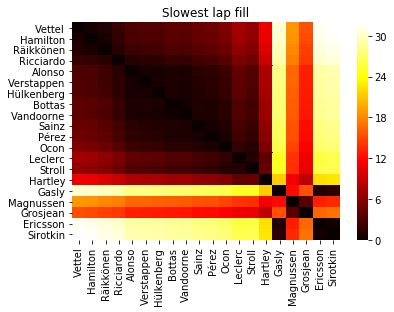

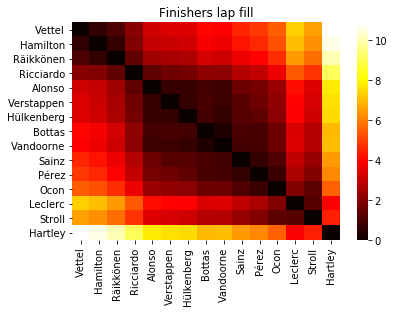

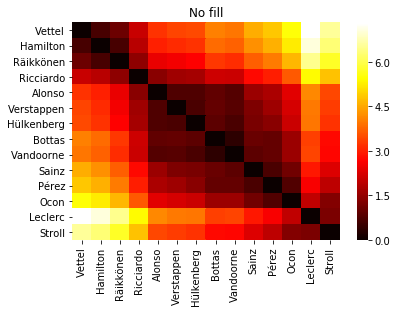

In [4]:
# Slowest Lap Times
sns.heatmap(distances_s, cmap="hot",
            xticklabels=names_s, yticklabels=names_s)
plt.title("Slowest lap fill")

# Finishers Lap Times
plt.figure()
sns.heatmap(distances_f, cmap="hot",
            xticklabels=names_f, yticklabels=names_f)
plt.title("Finishers lap fill")

# Ranking with missing values
plt.figure()
sns.heatmap(distances, cmap="hot",
            xticklabels=names, yticklabels=names)
plt.title("No fill");

In "03 Lap time differences", we had only seen the bottom two heatmaps (No Fill and Finishers lap fill) in Australia (raceId=989). The results made sense at that time. We could identify the top drivers (Vettel to Raikkonen and perhaps also Ricciardo), and when filling laps behind, we could also see that Hartley was far from the rest. Now that we've added the penalty for DNF's, we can see more. The drivers that did not finish have bright colors, while those who finished are in the darker top left square. This means that the penalty for DNF is working and (hopefully) it's not too drastic. A curious observation is that DNF'd drivers are close between them (bottom right dark-ish square). Also, Grosjean and Magnussen were doing reasonably ok before they left the race, so they are not as far behind as the other DNF's (their rows are orange instead of bright yellow).

In short, our ideas seem to **work well**!

# Some other methods (Drivers Rankings)
Now that our metric works well on a single race, we will try to get more from it. One thing we can try is to define a drivers ranking. The idea is the following: in a single race, the two drivers that have the largest distance between them are the first and last place. Everyone else is between them. We can detect who is in second place as the driver that is closest to first place; third place is second closest, and so on. The functions below implement this idea.

Finally, sort_matrix takes a square $n \times n$ matrix $M$ and a permutation $\sigma$ of $\{1, \dots, n\}$ and reorders the rows and columns of $M$ according to $\sigma$. For example, if $n=3$ and $\sigma$ is the permutation $(123)$ (ie. $\sigma$ sends 1 to 2, 2 to 3 and 3 to 1), sort_matrix moves the first row and column of $M$ to the second row and column, and so on.

Combining these ideas, we can sort a distance matrix according to our drivers ranking. The fastest driver will be in the first row (and column). The one closest to him will be in the second row, and so on. This is what extractdiam does. extractdiam2 does the opposite: the second to last driver is the one closest to last place, and so on (hopefully these two methods will give the same result, but I'm not 100% certain).

**Note:** To be honest, when we find the drivers that have the greatest distance between them, we can't find out who is faster (distances are symmetric). At this point, we can only guess who should be first place. If we don't get it right, it shouldn't change the end result too much. At worst, the distance matrix will be sorted from slowest to fastest instead of fastest to slowest. We might fix this in the future.

**Note 2:** We will also copy these functions into the Functions file.

In [5]:
def extractdiam(distmatrix):
    entriesmax=np.where( distmatrix==np.amax(distmatrix) )
    #print(entriesmax)
    i=entriesmax[0][0]
    n=distmatrix.shape[0]
    distancestopt=distmatrix[i,:]
    sorteddistancestopt=np.sort(distancestopt)
    indices=[]
    for k in range(0,n):
        indices.append(np.where(distmatrix[i,:] == sorteddistancestopt[k]))
    #newmatrix=np.delete(distmatrix,i,0)
    #newmatrix=np.delete(newmatrix,j,1)
    #return i,j,newmatrix
    return distancestopt, i,sorteddistancestopt, indices

def extractdiam2(distmatrix):
    entriesmax=np.where( distmatrix==np.amax(distmatrix) )
    #print(entriesmax)
    i=entriesmax[1][0]
    n=distmatrix.shape[0]
    distancestopt=distmatrix[i,:]
    sorteddistancestopt=-np.sort(-distancestopt, )
    indices=[]
    for k in range(0,n):
        indices.append(np.where(distmatrix[i,:] == sorteddistancestopt[k]))
    #newmatrix=np.delete(distmatrix,i,0)
    #newmatrix=np.delete(newmatrix,j,1)
    #return i,j,newmatrix
    return distancestopt, i,sorteddistancestopt, indices

def sort_matrix(matrix, sorted_indices):
    new_matrix = matrix.copy()
    n = len(sorted_indices)
    for i in range(n):
        for j in range(n):
            ii = sorted_indices[i]
            jj = sorted_indices[j]
            
            new_matrix[i][j] = matrix[ii][jj]
    
    return(new_matrix)

# Weighting each circuit
Not all circuits are the same. In general, we expect that lap time differences are bigger in circuits that have longer lap times. To define a season-wide metric, we want to eliminate this variance so that all races have a fair contribution.

To do this, we will weight each circuit by the fastest qualifying time. More specifically, let $D_i$ be the distance matrix in race $i$. We will define a distance matrix for the season as $D = \frac{\mu}{q_1} D_1 + \cdots + \frac{\mu}{q_n} D_n$, where:
- $n$ is the number of races in the season,
- $q_i$ is the fastest qualifying time in race $i$,
- $\mu$ is the average of all $q_i$'s.

In other words, the season distance matrix $D$ is a weighted sum of distance matrices coming from all the races in the season. The weights $\frac{\mu}{q_i}$ are smaller when $q_i$ is bigger and viceversa. This means that longer races will have a smaller effect on the season metric, whereas shorter races will have a bigger effect. This might sound contradictory, but think of it this way. We want all races to have a similar contribution in the final metric. Longer races have bigger gaps, so we fix that by reducing their contribution.

Naturally, we still need to verify somehow that this particular weighting makes sense. That is another topic for future work.

In [6]:
quals = pd.read_csv("f1db_csv/qualifying.csv")

best_times=[] 
for i in range(989,1010):
    best_times.append((quals >> mask( X.raceid==i,X.position==1)).q3.values[0])

def tomil(str):
    return float(str[0])*60000+float(str[2:4])*1000+float(str[5:8])

best_times_mil=list(map(tomil,best_times))
mu=sum(best_times_mil)/len(best_times_mil)
best_time_circuit={}
for i in range(989,1010):
    best_time_circuit[i]=best_times_mil[i-989]

weight_circuit={}    
for i in range(989,1010):
    weight_circuit[i]=mu / best_time_circuit[i]

def weightedmetric(metrics_races):
    newmetric=weight_circuit[989]*metrics_races[989]
    for i in range(990,1010):
        newmetric+=weight_circuit[i]*metrics_races[i]
    return newmetric

# Aggregating metrics
Finally, we have all the pieces ready to define a metric for the season. We fill in missing laps using the Slowest Lap method and the weights for each race are defined above. Let's see how we do.

In [7]:
races = SlowestLapTimes.raceId.values
races = np.unique(races)

metrics_races = {}
for race in races:
    distances, drivers = race_distances(race, df=SlowestLapTimes, season=True)
    metrics_races[race] = distances
    
    print(race, end="; ")

names = [driver_name(id) for id in drivers]
season_metric = weightedmetric(metrics_races)

989; 990; 991; 992; 993; 994; 995; 996; 997; 998; 999; 1000; 1001; 1002; 1003; 1004; 1005; 1006; 1007; 1008; 1009; 

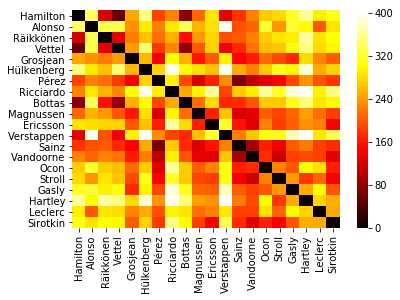

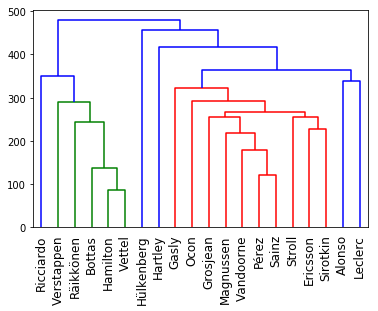

In [8]:
sns.heatmap(season_metric, cmap="hot", xticklabels=names, yticklabels=names)

plt.figure()
linked = linkage(season_metric);
diag = dendrogram(linked, labels=names, leaf_rotation=90)

Based on this distance matrix, we define a ranking of the drivers as described above. The new heatmap should have the fastest driver in the first row, and the slowest in the last.

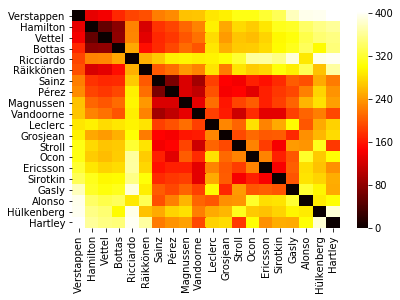

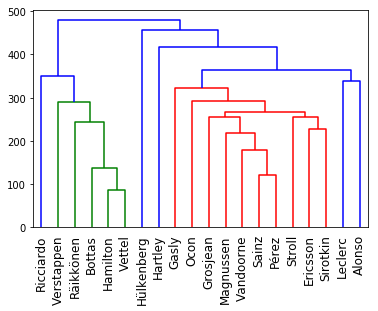

In [9]:
_, fp, dists, rankings = extractdiam(season_metric)
rankings = [l[0][0] for l in rankings]

season_metric2 = sort_matrix(season_metric, rankings)
names2 = [names[i] for i in rankings]

plot = sns.heatmap(season_metric2, cmap="hot", xticklabels=names2, yticklabels=names2)
season_heatmap = plot.get_figure()
#season_heatmap.savefig("results/Season heatmap.png", bbox_inches='tight')

plt.figure()
linked = linkage(season_metric2);
plot = dendrogram(linked, labels=names2, leaf_rotation=90)

season_dendrogram = plt.gcf()
#plt.savefig("results/Season Dendrogram.png", bbox_inches='tight')

We can also see if extractdiam2 gives something different.

['Verstappen', 'Ricciardo', 'Hülkenberg', 'Räikkönen', 'Hamilton', 'Vettel', 'Bottas', 'Alonso', 'Ocon', 'Grosjean', 'Leclerc', 'Sirotkin', 'Gasly', 'Magnussen', 'Pérez', 'Ericsson', 'Sainz', 'Vandoorne', 'Stroll', 'Hartley']


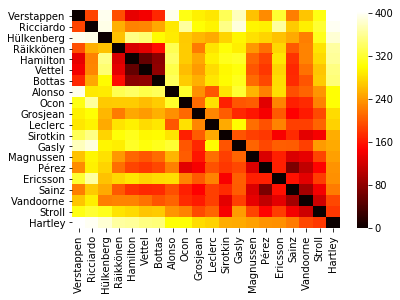

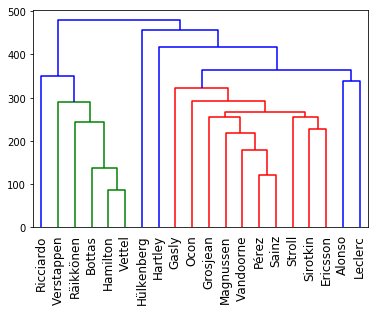

In [10]:
_, fp, dists, rankings = extractdiam2(season_metric)
rankings = [l[0][0] for l in rankings]

season_metric3 = sort_matrix(season_metric, rankings)
names3 = [names[i] for i in rankings]

print(names3)

sns.heatmap(season_metric3, cmap="hot", xticklabels=names3, yticklabels=names3)

plt.figure()
linked = linkage(season_metric3);
diag = dendrogram(linked, labels=names3, leaf_rotation=90)

As of now, neither extractdiam nor extractdiam2 give a ranking that can be easily interpreted (we expected Hamilton to rank higher, for example). Also, they give very different results. We will work with extractdiam, for lack of a better alternative, but we really want to fix this.